In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from attacks.universal_backdoor_attacks import universal_backdoor_attack
from utils.dataset import simDataset
from models.models import LSTM
from attacks.fgsm import Attack , Solver
from utils.dataset import load_model
import os

# --- Hyperparameters ---
learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = '/home/anhkhoa/ml4secu/save_path'
datapath = '/home/anhkhoa/ml4secu/data.csv'

# --- Load Dataset ---
train_dataset = simDataset(datapath=datapath, device=device, split='train')
test_dataset = simDataset(datapath=datapath, device=device, split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# FGSM Attack

In [ ]:
import numpy as np

model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model = load_model(model, os.path.join(save_path, f'{model.model_name}.pth'))
class Args:
    def __init__(self):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.cuda = torch.cuda.is_available()
        self.epoch = num_epochs
        self.batch_size = 32
        self.eps = 0.03
        self.lr = learning_rate
        self.y_dim = 2
        self.dataset = 'fraud'
        self.data_loader = {
            'train': train_loader,
            'test': test_loader
        }
        self.save_path = save_path

args = Args()


# --- Khởi tạo Solver ---
solver = Solver(args)
criterion = nn.CrossEntropyLoss()

accuracy_list = []
accuracy_before_defense_adv_list = []

for epsilon in np.arange(0, 0.11, 0.01):
    accuracy, accuracy_adv = solver.generate(
        num_sample=1000,
        target=None,
        epsilon=epsilon,
        alpha=0.01,
        iteration=10
    )
    accuracy_list.append(accuracy)
    accuracy_before_defense_adv_list.append(accuracy_adv)




Model loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM.pth
x_true shape: torch.Size([1000, 7]), y_true shape: torch.Size([1000])
Generate attack on batch size: 1000
Changed Predictions Indexes: []
[BEFORE] accuracy : 0.92 cost : 0.198
[AFTER]  accuracy : 0.92 cost : 0.198
x_true shape: torch.Size([1000, 7]), y_true shape: torch.Size([1000])
Generate attack on batch size: 1000
Changed Predictions Indexes: [0, 1, 3, 4, 7, 9, 11, 12, 16, 20, 21, 24, 25, 27, 28, 30, 39, 42, 43, 46, 49, 58, 61, 64, 65, 72, 73, 74, 76, 81, 87, 91, 95, 96, 102, 103, 106, 112, 113, 114, 115, 119, 124, 128, 131, 132, 133, 139, 142, 145, 146, 147, 148, 149, 152, 154, 155, 156, 157, 163, 164, 165, 169, 171, 172, 173, 174, 178, 183, 184, 185, 188, 189, 190, 191, 196, 202, 205, 208, 213, 217, 218, 219, 220, 222, 227, 228, 231, 232, 238, 242, 245, 247, 248, 251, 253, 254, 255, 259, 260, 261, 265, 266, 275, 276, 279, 282, 283, 292, 298, 299, 300, 303, 304, 306, 310, 311, 312, 315, 316, 320, 322, 325, 326

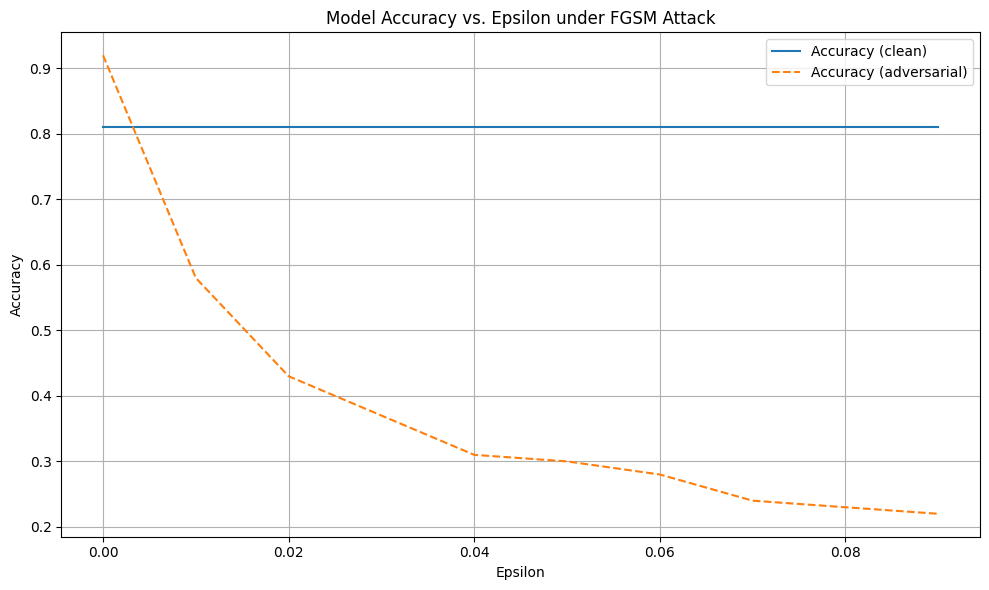

In [ ]:
import matplotlib.pyplot as plt
epsilon_values = list(np.arange(0, 0.11, 0.01))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracy_list, label='Accuracy (clean)')
plt.plot(epsilon_values, accuracy_before_defense_adv_list, label='Accuracy (adversarial)', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FGSM Attack')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Adversarial Training - FGSM Defense

In [11]:
%load_ext autoreload
%autoreload 2

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from attacks.universal_backdoor_attacks import universal_backdoor_attack
from utils.dataset import simDataset
from models.models import LSTM
from attacks.fgsm import Attack , Solver
from utils.dataset import load_model
import os

model = LSTM().to(device)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# model = load_model(model, os.path.join(save_path, f'{model.model_name}_adv.pth'))

# --- Gói các tham số vào args giả lập ---
class Args:
    def __init__(self):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.cuda = torch.cuda.is_available()
        self.epoch = num_epochs
        self.batch_size = 32
        self.eps = 0.03
        self.lr = learning_rate
        self.y_dim = 2
        self.dataset = 'fraud'
        self.data_loader = {
            'train': train_loader,
            'test': test_loader
        }
        self.save_path = save_path

args = Args()

# --- Khởi tạo Solver ---
solver = Solver(args)

solver.adv_train(train_loader=train_loader, val_loader=test_loader, num_epochs=num_epochs, alpha = 0.01, eps = 0.1)

[AdvTrain] Epoch 1/10:   0%|          | 0/411 [00:00<?, ?batch/s]

[AdvTrain] Epoch 1/10: 100%|██████████| 411/411 [00:06<00:00, 66.07batch/s, adv_loss=0.63] 


[AdvTrain] Epoch 1 - Avg Loss: 0.6300


[AdvTrain] Epoch 2/10: 100%|██████████| 411/411 [00:06<00:00, 64.02batch/s, adv_loss=0.608]


[AdvTrain] Epoch 2 - Avg Loss: 0.6078


[AdvTrain] Epoch 3/10: 100%|██████████| 411/411 [00:05<00:00, 69.48batch/s, adv_loss=0.556]


[AdvTrain] Epoch 3 - Avg Loss: 0.5562


[AdvTrain] Epoch 4/10: 100%|██████████| 411/411 [00:05<00:00, 73.03batch/s, adv_loss=0.477]


[AdvTrain] Epoch 4 - Avg Loss: 0.4765


[AdvTrain] Epoch 5/10: 100%|██████████| 411/411 [00:06<00:00, 61.13batch/s, adv_loss=0.395]


[AdvTrain] Epoch 5 - Avg Loss: 0.3954


[AdvTrain] Epoch 6/10: 100%|██████████| 411/411 [00:06<00:00, 64.17batch/s, adv_loss=0.38] 


[AdvTrain] Epoch 6 - Avg Loss: 0.3805


[AdvTrain] Epoch 7/10: 100%|██████████| 411/411 [00:06<00:00, 67.70batch/s, adv_loss=0.378]


[AdvTrain] Epoch 7 - Avg Loss: 0.3783


[AdvTrain] Epoch 8/10: 100%|██████████| 411/411 [00:05<00:00, 71.96batch/s, adv_loss=0.385]


[AdvTrain] Epoch 8 - Avg Loss: 0.3853


[AdvTrain] Epoch 9/10: 100%|██████████| 411/411 [00:05<00:00, 74.36batch/s, adv_loss=0.354]


[AdvTrain] Epoch 9 - Avg Loss: 0.3536


[AdvTrain] Epoch 10/10: 100%|██████████| 411/411 [00:06<00:00, 67.40batch/s, adv_loss=0.36] 


[AdvTrain] Epoch 10 - Avg Loss: 0.3601


Evaluating: 100%|██████████| 3286/3286 [00:11<00:00, 278.39batch/s, acc=83.41%]


Saving model


In [ ]:
model = load_model(model, os.path.join(save_path, f'{model.model_name}_adv.pth'))
solver.model = model

accuracy_list = []
accuracy_after_defense_adv_list = []
import numpy as np
for epsilon in np.arange(0, 0.11, 0.01):
    accuracy, accuracy_adv = solver.generate(
        num_sample=1000,
        target=None,
        epsilon=epsilon,
        alpha=0.01,
        iteration=10
    )
    accuracy_list.append(accuracy)
    accuracy_after_defense_adv_list.append(accuracy_adv)

Model loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_adv.pth
x_true shape: torch.Size([1000, 7]), y_true shape: torch.Size([1000])
Generate attack on batch size: 1000
Changed Predictions Indexes: []
[BEFORE] accuracy : 0.83 cost : 0.342
[AFTER]  accuracy : 0.83 cost : 0.342
x_true shape: torch.Size([1000, 7]), y_true shape: torch.Size([1000])
Generate attack on batch size: 1000
Changed Predictions Indexes: [57, 254, 266, 436, 451, 562, 655, 700, 714, 796, 821, 933, 964, 977, 993]
[BEFORE] accuracy : 0.83 cost : 0.342
[AFTER]  accuracy : 0.82 cost : 0.355
x_true shape: torch.Size([1000, 7]), y_true shape: torch.Size([1000])
Generate attack on batch size: 1000
Changed Predictions Indexes: [36, 57, 105, 175, 203, 254, 255, 266, 267, 384, 436, 444, 451, 454, 562, 612, 655, 700, 714, 717, 796, 821, 933, 964, 977, 985, 993]
[BEFORE] accuracy : 0.83 cost : 0.342
[AFTER]  accuracy : 0.80 cost : 0.368
x_true shape: torch.Size([1000, 7]), y_true shape: torch.Size([1000])
Generate 

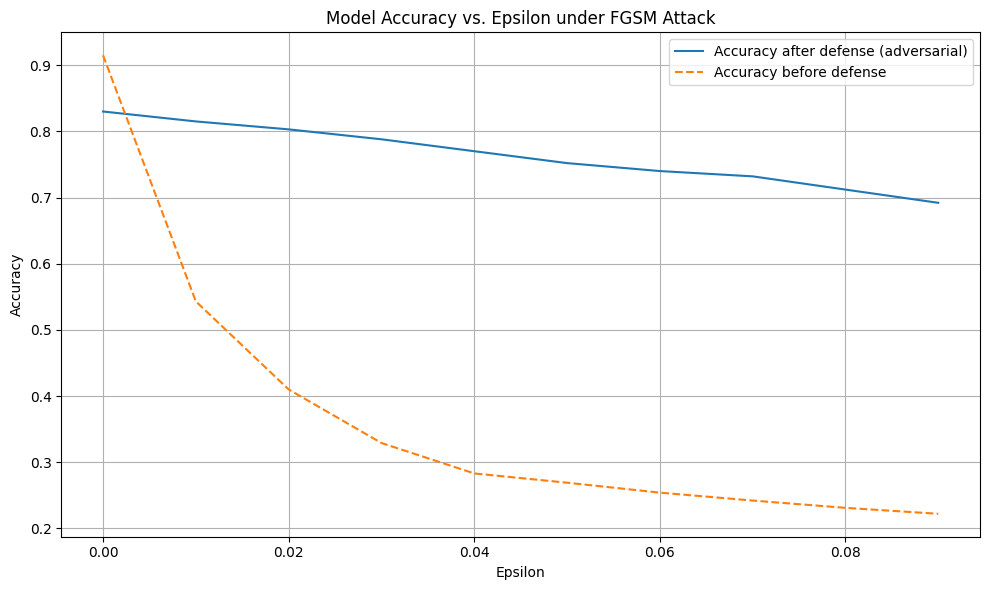

In [ ]:
import matplotlib.pyplot as plt
epsilon_values = list(np.arange(0, 0.11, 0.01))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracy_after_defense_adv_list, label='Accuracy after defense (adversarial)')
plt.plot(epsilon_values, accuracy_before_defense_adv_list, label='Accuracy before defense', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FGSM Attack')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Label Flipping poisoning Attack

In [ ]:
from defences.knn_based_defense import knn_based_defense
from attacks.falfa import falfa
from utils.dataset import save_model, load_model_state
import numpy as np


range_attack = np.arange(0, 0.5, 0.05)

In [5]:
range_attack

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])

## Train and save clean model

In [4]:
model = LSTM().to(device)

# Loss function and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = nn.CrossEntropyLoss() # Others loss function use
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from tqdm import tqdm

# Train the network
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader, 
                       desc=f'Epoch {epoch+1}/{num_epochs}', 
                       unit='batch')
    
    for batch_id, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.type_as(outputs)
        loss = criterion(outputs.squeeze(), labels.long())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': running_loss/(batch_id+1)})
    
    print(f'Epoch {epoch+1} - Avg Loss: {running_loss/len(train_loader):.4f}')

save_model(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))

Epoch 1/10: 100%|██████████| 411/411 [00:08<00:00, 49.64batch/s, loss=0.6]  


Epoch 1 - Avg Loss: 0.6002


Epoch 2/10: 100%|██████████| 411/411 [00:04<00:00, 95.21batch/s, loss=0.581] 


Epoch 2 - Avg Loss: 0.5811


Epoch 3/10: 100%|██████████| 411/411 [00:04<00:00, 92.36batch/s, loss=0.565]


Epoch 3 - Avg Loss: 0.5652


Epoch 4/10: 100%|██████████| 411/411 [00:05<00:00, 78.00batch/s, loss=0.401]


Epoch 4 - Avg Loss: 0.4008


Epoch 5/10: 100%|██████████| 411/411 [00:04<00:00, 91.32batch/s, loss=0.332]


Epoch 5 - Avg Loss: 0.3319


Epoch 6/10: 100%|██████████| 411/411 [00:04<00:00, 92.05batch/s, loss=0.308]


Epoch 6 - Avg Loss: 0.3081


Epoch 7/10: 100%|██████████| 411/411 [00:04<00:00, 87.87batch/s, loss=0.299]


Epoch 7 - Avg Loss: 0.2987


Epoch 8/10: 100%|██████████| 411/411 [00:04<00:00, 84.39batch/s, loss=0.318]


Epoch 8 - Avg Loss: 0.3181


Epoch 9/10: 100%|██████████| 411/411 [00:04<00:00, 93.45batch/s, loss=0.3]  


Epoch 9 - Avg Loss: 0.3004


Epoch 10/10: 100%|██████████| 411/411 [00:04<00:00, 92.78batch/s, loss=0.287]


Epoch 10 - Avg Loss: 0.2870
Model saved successfully to /home/anhkhoa/ml4secu/save_path/LSTM_falfa


In [6]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() # Others loss function use
from torch.utils.data import DataLoader, TensorDataset
num_epochs = 3

accu_poisend_list = []
accu_defense_list = []

for eps in range_attack:
    model_attack , optimizer_attack = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))

    falfa_runner = falfa(
        model=model_attack,
        device=device,
        epochs=num_epochs,
        epsilon=eps,           
        max_iter=1,
        criterion=criterion,
        optimizer=optimizer_attack
    )


    poisoned_labels = falfa_runner.falfa_attack_dl_dataloader(
        dataloader=train_loader,
        X_np=train_dataset.x,
        y_np=train_dataset.y
    )


    X_tensor = torch.tensor(train_dataset.x, dtype=torch.float)
    y_poisoned_tensor = torch.tensor(poisoned_labels, dtype=torch.int64)
    poisoned_dataset = TensorDataset(X_tensor, y_poisoned_tensor)
    poisoned_loader = DataLoader(poisoned_dataset, batch_size=32, shuffle=True)
    
    falfa_runner.poisoned_labels = poisoned_labels
    falfa_runner.train_model_on_loader(poisoned_loader)

    accu_poisned = falfa_runner.evaluate_model(
        dataloader = test_loader,
        device = 'cuda'
    )

    accu_poisend_list.append(accu_poisned)
    print(f"Accuracy after attack: {accu_poisned:.4f}")

    # --- KNN-based Defense ---
    
    knn_defense = knn_based_defense(k = 5, eta = 0.6) # 5, 0.8
    cleaned_train_loader = knn_defense.apply_defense(
        X  = train_dataset.x,
        y_poisoned = poisoned_labels,
        y_clean = train_dataset.y,
    )

    model_clean , optimizer_clean = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))

    model_defensed = knn_defense.train_model_after_defense(
        model = model_clean,
        optimizer = optimizer_clean,
        cleaned_loader = cleaned_train_loader,
        num_epochs = num_epochs,
        criterion = criterion
    )

    # Evaluate the model after defense
    accuracy_defense = knn_defense.evaluate_model(
        model = model_defensed,
        test_loader = test_loader,
        device = 'cuda'
    )

    accu_defense_list.append(accuracy_defense)
    
    print(f"Accuracy after defense: {accuracy_defense:.4f}")


Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


✅ Converged early.


Accuracy after attack: 0.4863
🔁 Number of relabeled samples by kNN defense: 955
✅ Precision of relabeled samples: 0.0000 (0/955)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.9047
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.4982
🔁 Number of relabeled samples by kNN defense: 1638
✅ Precision of relabeled samples: 0.3718 (609/1638)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.9099
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.4982
🔁 Number of relabeled samples by kNN defense: 2256
✅ Precision of relabeled samples: 0.4867 (1098/2256)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8926
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.4982
🔁 Number of relabeled samples by kNN defense: 2951
✅ Precision of relabeled samples: 0.5161 (1523/2951)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8904
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.4982
🔁 Number of relabeled samples by kNN defense: 3616
✅ Precision of relabeled samples: 0.5951 (2152/3616)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8530
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.4568
🔁 Number of relabeled samples by kNN defense: 4482
✅ Precision of relabeled samples: 0.6029 (2702/4482)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8834
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.4976
🔁 Number of relabeled samples by kNN defense: 5181
✅ Precision of relabeled samples: 0.5972 (3094/5181)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8071
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.5018
🔁 Number of relabeled samples by kNN defense: 5593
✅ Precision of relabeled samples: 0.5689 (3182/5593)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8771
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.5018
🔁 Number of relabeled samples by kNN defense: 6140
✅ Precision of relabeled samples: 0.5482 (3366/6140)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8424
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


🔁 Iteration 1/1


Accuracy after attack: 0.5097
🔁 Number of relabeled samples by kNN defense: 6460
✅ Precision of relabeled samples: 0.5280 (3411/6460)
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa
Accuracy after defense: 0.8576


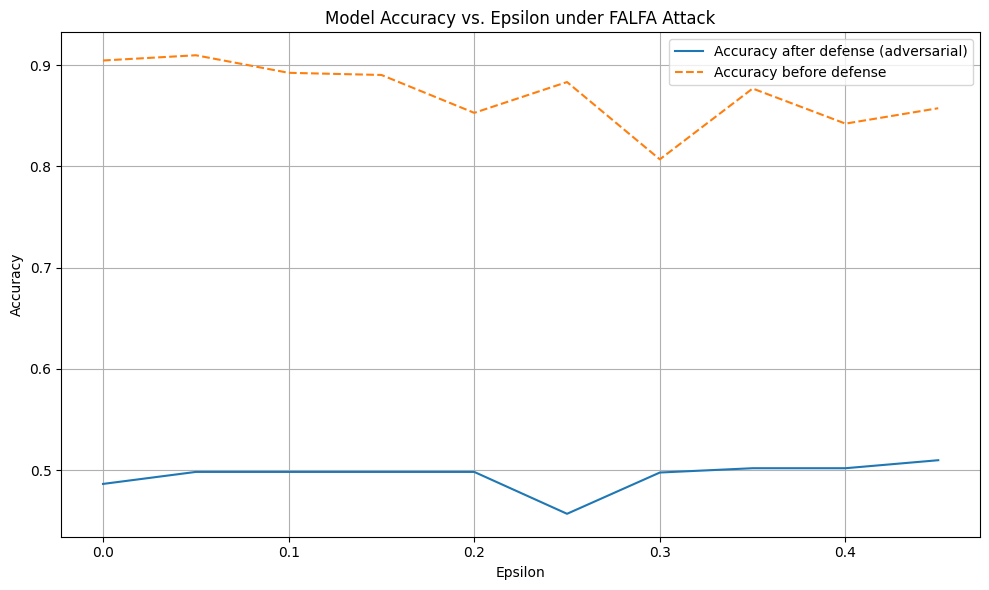

In [9]:
import matplotlib.pyplot as plt
range_attack = np.arange(0, 0.5, 0.05)
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range_attack, accu_poisend_list, label='Accuracy after defense (adversarial)')
plt.plot(range_attack, accu_defense_list, label='Accuracy before defense', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FALFA Attack')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Spectral Signature Defense & Pruning Defense

In [2]:
from defences.ss_for_backdoor import spectral_signature_defense, plotCorrelationScores, extract_features
from torch.utils.data import Subset
from utils.dataset import load_model_state

In [ ]:
# --- Initialize Model ---
num_epochs = 3
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


# --- Initialize Attack ---
attack = universal_backdoor_attack(
    device=device,
    model=model,
    data_obj=(train_loader, test_loader),
    target_label=0,
    mu=0.1,
    beta=0.01,
    lambd=0.01,
    epsilon=1.0,
    save_path=save_path
)
from utils.dataset import load_model_state
import os
model, optimizer = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))
attack.model = model


# --- Select & Rank ---
attack.select_non_target_samples(train_dataset.get_data()) # select het non target samples , target 0 , non target 1 
attack.confidence_based_sample_ranking(batch_size=32) # 

# --- Trigger Creation ---
attack.define_trigger(train_dataset.get_data())
attack.compute_mode(train_dataset.get_data())
attack.optimize_trigger(num_epochs=200)
# attack.load_trigger('/home/anhkhoa/ml4secu/save_path/saved_triggers/trigger_delta.pt')

print("✅ Trigger optimized:\n", attack.delta)
print("✅ Mode vector:\n", attack.mode_vector)

# # --- Poison Datasets ---
poisoned_trainset, poisoned_train_samples = attack.construct_poisoned_dataset(train_dataset.get_data(), epsilon=0.3)
poisoned_testset, poisoned_test_samples = attack.construct_poisoned_dataset(test_dataset.get_data(), epsilon=1.0)
# attack.load_poisoned_dataset('/home/anhkhoa/ml4secu/save_path/saved_datasets/poisoned_dataset.pt')

# poisoned_trainset, poisoned_testset = attack.poisoned_dataset   


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
attack.model = model
# --- Reload DataLoaders ---
poisoned_train_loader = DataLoader(poisoned_trainset, batch_size=32, shuffle=True)
poisoned_test_loader = DataLoader(poisoned_testset, batch_size=32, shuffle=False)

# --- Train on Poisoned Dataset ---
attack.train((poisoned_train_loader, poisoned_test_loader), num_epochs, criterion, optimizer)

attack.generate(
    clean_dataset=train_dataset,
)

poisoned_indices = []
    # 
poisoned_samples_set = set(tuple(sample.tolist()) for sample, _ in poisoned_train_samples)

# Iterate over poisoned_trainset to find indices of poisoned samples
for idx, (sample, _) in enumerate(poisoned_trainset):
    # Convert the sample to a tuple for comparison
    sample_tuple = tuple(sample.tolist())
    
    # Check if the sample is in the poisoned_samples_set
    if sample_tuple in poisoned_samples_set:
        poisoned_indices.append(idx)


features = extract_features(model, poisoned_trainset)

labels = poisoned_trainset.tensors[-1].cpu().numpy()

class_list = [num for num in range(len(set(labels)))]

suspicious_idx, scores_dict = spectral_signature_defense(
    features,
    labels=labels,
    class_list=class_list,
    expected_poison_fraction=0.3,
    extra_multiplier=1.5
)
suspicious_set = set(suspicious_idx)
all_indices = list(range(len(poisoned_trainset)))
clean_indices = [i for i in all_indices if i not in suspicious_set]

X_tensor = poisoned_trainset.tensors[0][clean_indices]
y_tensor = poisoned_trainset.tensors[1][clean_indices]

X = X_tensor.detach().cpu().numpy()
y = y_tensor.detach().cpu().numpy()

# Tạo lại dataset cùng class gốc
cleaned_trainset = simDataset(X = X , y = y, device = 'cuda')
model, optimizer = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))
attack.model = model
attack.train() # train voi data sau khi cleaned 

attack.generate(
    clean_dataset=cleaned_trainset,
)

2025-05-13 21:50:21,899 - INFO - Attack initialized with target label: 0
2025-05-13 21:50:21,951 - INFO - Selecting non-target samples from the training dataset...
2025-05-13 21:50:21,953 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-13 21:50:21,956 - INFO - Starting confidence-based sample ranking...
/home/anhkhoa/ml4secu/utils/dataset.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.x[idx], dtype=torch.float).to(self.device)
/home/anhkhoa/ml4secu/utils/dataset.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.y[idx], dtype=torch.int64).to(self.device)


Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-13 21:50:25,011 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-13 21:50:25,042 - INFO - Selected 657 samples for further processing.
2025-05-13 21:50:25,047 - INFO - Defining the universal trigger pattern (delta)...
2025-05-13 21:50:25,048 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-13 21:50:25,052 - INFO - Min and max values computed successfully.
2025-05-13 21:50:25,055 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-13 21:50:25,057 - INFO - Computing mode vector of the entire training dataset...
2025-05-13 21:50:25,070 - INFO - Mode vector computed successfully.
2025-05-13 21:50:25,072 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-13 21:50:25,928 - INFO - Epoch [10/200], Loss: 1.6792
2025-05-13 21:50:26,839 - INFO - Epoch [20/200], Loss: 1.6120
2025-05-13 21:50:27,718 - INFO - Epoch [30/200], Loss: 1.5685
2025-05-13 21:50:28,501 - INFO - E

✅ Trigger optimized:
 tensor([-2.0478e-01,  7.1520e-05,  4.4517e-02, -2.4839e-02,  2.1526e-02,
         5.5547e-02, -1.3503e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 118.82batch/s, loss=0.588]


Epoch 1 - Avg Loss: 0.5879


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 107.91batch/s, loss=0.567]


Epoch 2 - Avg Loss: 0.5667


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 126.46batch/s, loss=0.541]


Epoch 3 - Avg Loss: 0.5415


Evaluating: 100%|██████████| 103/103 [00:00<00:00, 248.29batch/s, acc=85.85%]


Saving model


2025-05-13 21:50:52,212 - INFO - [Generate Attack] Non-target triggered samples: 6576. ASR: 70.26%
2025-05-13 21:50:52,213 - INFO - Precision : 29.74%
2025-05-13 21:50:54,662 - INFO - [Generate Attack] Non-target triggered samples: 2533. ASR: 89.62%
2025-05-13 21:50:54,664 - INFO - Precision : 10.38%


89.61705487564153